<a href="https://colab.research.google.com/github/rybak97/SR_cartoon/blob/main/FSRCNN_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization

from scipy import signal
from scipy import ndimage

from matplotlib import pyplot as plt

import math

import cv2 as cv
import numpy as np

import os
from PIL import Image

ImportError: ignored

1. Network

In [2]:
_inputs  = Input(shape=(128, 128, 3), name='input')
C1 = Conv2D(filters=64, kernel_size=5, strides = 1, padding='same')(_inputs)
C2 = Conv2D(filters=128, kernel_size=1, strides = 1, padding='same')(C1)
C5 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C2)
C6 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C5)
C7 = Conv2D(filters=256, kernel_size=3, strides = 1, padding='same')(C6)
C9 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C7)
C10 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C9)
C12 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C10)
C13 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(C12)
C14 = Conv2D(filters=32, kernel_size=1, strides = 1, padding='same')(C13)

D1 = Conv2D(filters=3, kernel_size=9, strides = 1, padding='same')(C14)
model = keras.Model(inputs=_inputs, outputs=D1)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     8320      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 256)     147712    
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      147520

2. Preparing data

In [3]:
ishape = 128

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


train_image = train_images[0:5000]
test_image  = test_images[0:500]


X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.

y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.

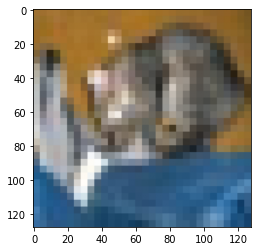

In [4]:
plt.imshow(X_test[0])

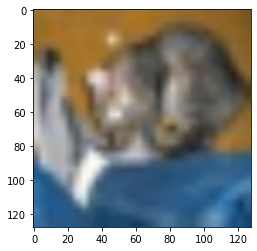

In [5]:
plt.imshow(y_test[0])

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='mse',       
              metrics=['mae'])    

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model.save('FSRCNN.h5')
model.save_weights('model_weights.h5')

Epoch 1/3
63/63 [==============================] - 138s 2s/step - loss: 0.0205 - mae: 0.0850 - val_loss: 0.0060 - val_mae: 0.0399
Epoch 2/3
63/63 [==============================] - 99s 2s/step - loss: 0.0039 - mae: 0.0335 - val_loss: 0.0021 - val_mae: 0.0260
Epoch 3/3
63/63 [==============================] - 99s 2s/step - loss: 0.0013 - mae: 0.0220 - val_loss: 8.9313e-04 - val_mae: 0.0202
16/16 - 8s - loss: 9.3339e-04 - mae: 0.0208 - 8s/epoch - 476ms/step
Test loss: 0.0009333852212876081
Test mae: 0.0208189245313406


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


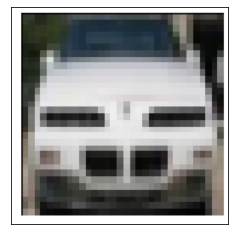

In [8]:
ishape = 128

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


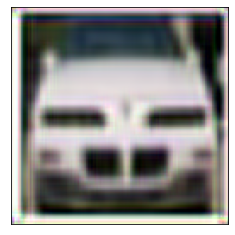

In [9]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.


img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [10]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([19.393785], shape=(1,), dtype=float32)


In [11]:
img = tf.reshape(img, [128,128,3,1])

img_SR = tf.reshape(img_SR, [128,128,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.58170384


3. Pokemon dataset

In [11]:
_inputs  = Input(shape=(120, 120, 3), name='input')
C1 = Conv2D(filters=64, kernel_size=5, strides = 1, padding='same')(_inputs)
C2 = Conv2D(filters=128, kernel_size=1, strides = 1, padding='same')(C1)
C5 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C2)
C6 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C5)
C7 = Conv2D(filters=256, kernel_size=3, strides = 1, padding='same')(C6)
C9 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C7)
C10 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C9)
C12 = Conv2D(filters=64, kernel_size=3, strides = 1, padding='same')(C10)
C13 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(C12)
C14 = Conv2D(filters=32, kernel_size=1, strides = 1, padding='same')(C13)

D1 = Conv2D(filters=3, kernel_size=9, strides = 1, padding='same')(C14)

model2 = keras.Model(inputs=_inputs, outputs=D1)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 120, 120, 64)      4864      
                                                                 
 conv2d_12 (Conv2D)          (None, 120, 120, 128)     8320      
                                                                 
 conv2d_13 (Conv2D)          (None, 120, 120, 64)      73792     
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 120, 64)      36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 120, 120, 256)     147712    
                                                                 
 conv2d_16 (Conv2D)          (None, 120, 120, 64)      1475

In [3]:
images = []


for file in os.listdir('/content/drive/MyDrive/images/'):
    images.append(cv.imread('/content/drive/MyDrive/images/{}'.format(file)))

In [4]:
ishape = 120

for a in range(len(images)):
  images[a] = cv.cvtColor(images[a], cv.COLOR_BGR2RGB)



train_image = images[0:647]
test_image  = images[647:]

train_image2 = images[0:647] #czyste
test_image2  = images[647:]



for i in range(np.asarray(647)):

  
  train_image[i] = cv.blur(train_image[i],(7,7))
   


for i in range(np.asarray(809-647)):

  
  test_image[i] = cv.blur(test_image[i],(7,7))
 

X_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.


y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image2]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image2]) / 255.

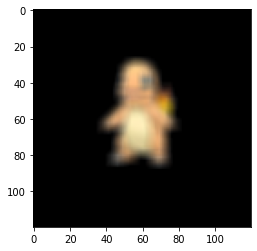

In [5]:
plt.imshow(X_test[77])

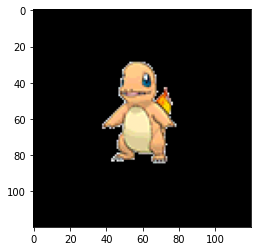

In [6]:
plt.imshow(y_test[77])

In [15]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.00005),
              loss='mse',       
              metrics=['mae'])    

history = model2.fit(X_train, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.2)

test_scores = model2.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])



Epoch 1/30
17/17 [==============================] - 13s 708ms/step - loss: 0.0145 - mae: 0.0536 - val_loss: 0.0077 - val_mae: 0.0384
Epoch 2/30
17/17 [==============================] - 12s 697ms/step - loss: 0.0078 - mae: 0.0378 - val_loss: 0.0071 - val_mae: 0.0353
Epoch 3/30
10/17 [================>.............] - ETA: 4s - loss: 0.0072 - mae: 0.0354

KeyboardInterrupt: ignored

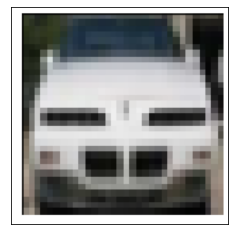

In [16]:
ishape = 120

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


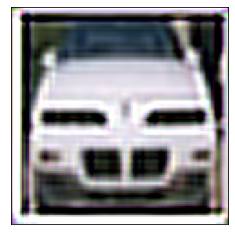

In [17]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model2.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [18]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([15.016764], shape=(1,), dtype=float32)


In [19]:
img = tf.reshape(img, [120,120,3,1])

img_SR = tf.reshape(img_SR, [120,120,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.47831002
